In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping

In [13]:
# Adjust the file paths if needed based on your download method
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# If the dataset doesn't have headers, add them
if len(train_data.columns) == 1:
    train_data = pd.read_csv('train.csv', header=None)
    train_data.columns = ['label', 'title', 'description']
    
    test_data = pd.read_csv('test.csv', header=None)
    test_data.columns = ['label', 'title', 'description']

# Display sample data
train_data.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [14]:
print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

Training data shape: (120000, 3)
Testing data shape: (7600, 3)


Class distribution in training data:
Class Index
3    30000
4    30000
2    30000
1    30000
Name: count, dtype: int64


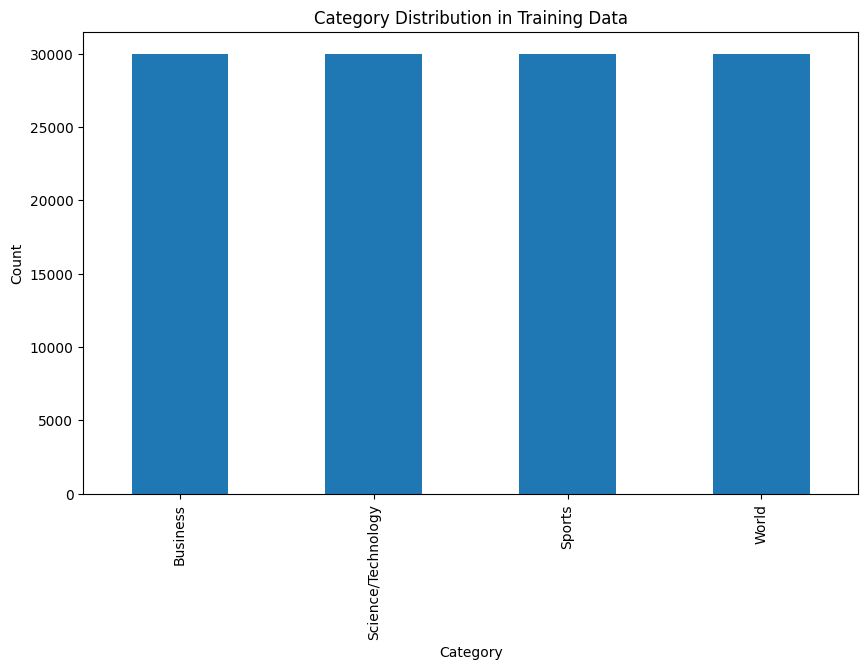

In [15]:
print("Class distribution in training data:")
print(train_data['Class Index'].value_counts())

# Map label IDs to category names
label_mapping = {
    1: "World",
    2: "Sports",
    3: "Business",
    4: "Science/Technology"
}

# Apply mapping to show class distribution with names
train_data['category'] = train_data['Class Index'].map(label_mapping)
test_data['category'] = test_data['Class Index'].map(label_mapping)

# Plot class distribution
plt.figure(figsize=(10, 6))
train_data['category'].value_counts().plot(kind='bar')
plt.title('Category Distribution in Training Data')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

In [16]:
train_data['content'] = train_data['Title'] + " " + train_data['Description']
test_data['content'] = test_data['Title'] + " " + test_data['Description']

# Display sample
train_data[['content', 'category']].head()

,content,category
0,Wall St. Bears Claw Back Into the Black (Reute...,Business
1,Carlyle Looks Toward Commercial Aerospace (Reu...,Business
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,Business
3,Iraq Halts Oil Exports from Main Southern Pipe...,Business
4,"Oil prices soar to all-time record, posing new...",Business


In [17]:
# Adjust label to be 0-indexed (for use with categorical_crossentropy)
train_data['label'] = train_data['Class Index'] - 1
test_data['label'] = test_data['Class Index'] - 1

# Prepare data for modeling
X_train = train_data['content'].values
y_train = train_data['label'].values
X_test = test_data['content'].values
y_test = test_data['label'].values

# Split training data to get a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:
max_words = 20000  # Maximum number of words in the vocabulary
max_sequence_length = 100  # Maximum sequence length

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train) 
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_sequence_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post', truncating='post')

# Convert labels to categorical (one-hot encoded)
num_classes = 4  # AG News has 4 categories
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

In [19]:
embedding_dim = 128
vocab_size = len(tokenizer.word_index) + 1  # Add 1 for OOV token
if vocab_size > max_words:
    vocab_size = max_words

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    SpatialDropout1D(0.2),
    LSTM(embedding_dim, dropout=0.2, recurrent_dropout=0.2),
    Dense(num_classes, activation='softmax')
])

model.summary()

c:\Users\kowlin\anaconda3\envs\nlp\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [21]:
batch_size = 64
epochs = 10

history = model.fit(
    X_train_pad, y_train_cat,
    validation_data=(X_val_pad, y_val_cat),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping]
)

Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 174s 102ms/step - accuracy: 0.2509 - loss: 1.3874 - val_accuracy: 0.2501 - val_loss: 1.3851
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 167s 99ms/step - accuracy: 0.2998 - loss: 1.3102 - val_accuracy: 0.8813 - val_loss: 0.3907
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 137s 81ms/step - accuracy: 0.8986 - loss: 0.3282 - val_accuracy: 0.9158 - val_loss: 0.2601
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 138s 82ms/step - accuracy: 0.9350 - loss: 0.2125 - val_accuracy: 0.9193 - val_loss: 0.2447
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 172s 102ms/step - accuracy: 0.9499 - loss: 0.1652 - val_accuracy: 0.9199 - val_loss: 0.2529
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 163s 97ms/step - accuracy: 0.9573 - loss: 0.1380 - val_accuracy: 0.9197 - val_loss: 0.2577
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 151s 90ms/step - accuracy: 0.9657 - loss: 0.1099 - val_accuracy: 0.9154 - val_loss: 0.2800


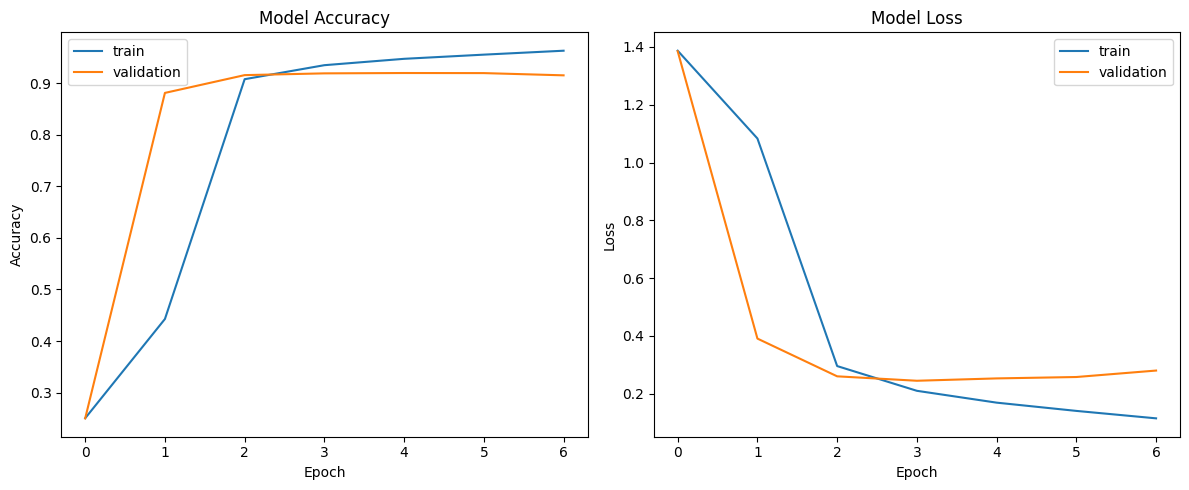

In [22]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
loss, accuracy = model.evaluate(X_test_pad, y_test_cat)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9129 - loss: 0.2724
Test Loss: 0.2531
Test Accuracy: 0.9199
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9129 - loss: 0.2724
Test Loss: 0.2531
Test Accuracy: 0.9199


238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
Classification Report:
                    precision    recall  f1-score   support

             World       0.92      0.91      0.91      1900
            Sports       0.96      0.98      0.97      1900
          Business       0.89      0.89      0.89      1900
Science/Technology       0.90      0.91      0.91      1900

          accuracy                           0.92      7600
         macro avg       0.92      0.92      0.92      7600
      weighted avg       0.92      0.92      0.92      7600

Classification Report:
                    precision    recall  f1-score   support

             World       0.92      0.91      0.91      1900
            Sports       0.96      0.98      0.97      1900
          Business       0.89      0.89      0.89      1900
Science/Technology       0.90      0.91      0.91      1900

          accuracy                           0.92      7600
         macro avg       

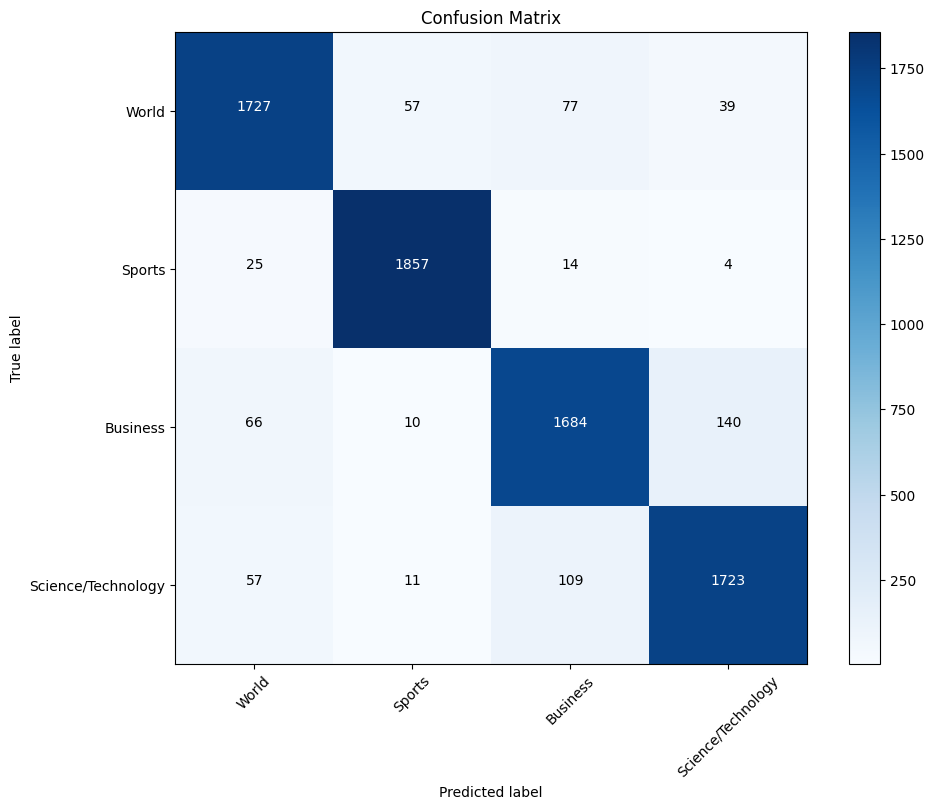

In [24]:
y_pred_prob = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_decoded = np.argmax(y_test_cat, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_test_decoded, y_pred, target_names=list(label_mapping.values())))

# Confusion matrix
cm = confusion_matrix(y_test_decoded, y_pred)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(label_mapping.values()))
plt.xticks(tick_marks, label_mapping.values(), rotation=45)
plt.yticks(tick_marks, label_mapping.values())

fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [25]:
def predict_thread_category(thread_content):
    """Predict the category for a new thread based on its content."""
    # Tokenize and pad the input text
    sequence = tokenizer.texts_to_sequences([thread_content])
    padded = pad_sequences(sequence, maxlen=max_sequence_length, padding='post', truncating='post')
    
    # Make prediction
    prediction = model.predict(padded)[0]
    predicted_category_id = np.argmax(prediction)
    
    # Map back to category name (add 1 because our model outputs 0-indexed but mapping is 1-indexed)
    category_name = label_mapping[predicted_category_id + 1]
    confidence = float(prediction[predicted_category_id]) * 100
    
    # Get top 2 categories for suggestion
    top_categories = []
    sorted_indices = np.argsort(prediction)[::-1][:2]  # Get indices of top 2 predictions
    
    for idx in sorted_indices:
        top_categories.append({
            'category': label_mapping[idx + 1],
            'confidence': float(prediction[idx]) * 100
        })
    
    return {
        'predicted_category': category_name,
        'confidence': confidence,
        'top_suggestions': top_categories
    }

In [26]:
example_threads = [
    "UEFA Champions League: Barcelona defeats Bayern Munich in an exciting match. Lewandowski scores a hat-trick.",
    "Stock markets plunge amid fears of economic recession. Dow Jones drops 500 points.",
    "Apple unveils new iPhone with revolutionary AI capabilities and improved battery life.",
    "Climate summit results in new international agreement to reduce carbon emissions by 2030."
]

for i, thread in enumerate(example_threads):
    result = predict_thread_category(thread)
    print(f"\nExample Thread {i+1}: {thread}")
    print(f"Predicted Category: {result['predicted_category']} (Confidence: {result['confidence']:.2f}%)")
    print("Top Suggestions:")
    for suggestion in result['top_suggestions']:
        print(f"  - {suggestion['category']} (Confidence: {suggestion['confidence']:.2f}%)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

Example Thread 1: UEFA Champions League: Barcelona defeats Bayern Munich in an exciting match. Lewandowski scores a hat-trick.
Predicted Category: Sports (Confidence: 98.63%)
Top Suggestions:
  - Sports (Confidence: 98.63%)
  - World (Confidence: 1.28%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Example Thread 1: UEFA Champions League: Barcelona defeats Bayern Munich in an exciting match. Lewandowski scores a hat-trick.
Predicted Category: Sports (Confidence: 98.63%)
Top Suggestions:
  - Sports (Confidence: 98.63%)
  - World (Confidence: 1.28%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

Example Thread 2: Stock markets plunge amid fears of economic recession. Dow Jones drops 500 points.
Predicted Category: Business (Confidence: 98.13%)
Top Suggestions:
  - Business (Confidence: 98.13%)
  - World (Confidence: 1.51%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Example Thread 2: Stock marke

In [28]:
# Save the model with error handling
try:
    # Try saving in H5 format (often more reliable)
    model.save('thread_category_model.h5')
    print("Model saved successfully in H5 format")
except Exception as e:
    print(f"Error saving model in H5 format: {e}")
    try:
        # Try alternative SavedModel format
        import os
        # Make sure the directory exists
        if not os.path.exists('thread_category_model'):
            os.makedirs('thread_category_model')
        model.save('thread_category_model')
        print("Model saved successfully in SavedModel format")
    except Exception as e:
        print(f"Error saving model in SavedModel format: {e}")
        # Last resort - save weights only
        model.save_weights('thread_category_model_weights')
        print("Only model weights were saved")

# Save the tokenizer
import pickle
try:
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("Tokenizer saved successfully")
except Exception as e:
    print(f"Error saving tokenizer: {e}")

Model saved successfully in H5 format
Tokenizer saved successfully


In [30]:
def load_model_and_predict(thread_content):
    # Load model
    try:
        # Try loading H5 format first
        loaded_model = tf.keras.models.load_model('thread_category_model.h5')
    except:
        # Fall back to SavedModel format
        try:
            loaded_model = tf.keras.models.load_model('thread_category_model')
        except:
            # Last resort - load model architecture and weights separately
            loaded_model = model  # Use current model architecture
            loaded_model.load_weights('thread_category_model_weights')
    
    # Load tokenizer
    with open('tokenizer.pickle', 'rb') as handle:
        loaded_tokenizer = pickle.load(handle)
    
    # Tokenize and pad
    sequence = loaded_tokenizer.texts_to_sequences([thread_content])
    padded = pad_sequences(sequence, maxlen=max_sequence_length, padding='post', truncating='post')
    
    # Predict
    prediction = loaded_model.predict(padded)[0]
    predicted_category_id = np.argmax(prediction)
    
    # Map to category name
    category_name = label_mapping[predicted_category_id + 1]
    confidence = float(prediction[predicted_category_id]) * 100
    
    return category_name, confidence